# CNN Prediction

In [3]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

import function_dl as func_dl

Tensorflow version 2.2.0
Tensorflow version 2.2.0


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Processing

In [5]:
img_width, img_height = 224, 224

In [12]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

In [13]:
# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

In [14]:
# ## For splited rare deletions
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_del_splits.list'

In [15]:
# ## For splited rare duplications
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [16]:
# true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [17]:
# true_images_path_list  = true_cnv_df['image_path']
# false_images_path_list = false_cnv_df['image_path']

In [18]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

In [12]:
## For pcgc experimental cnvs
cnv_info_file = '/home/rt2776/cnv_espresso/predict_pcgc/images_new/pcgc_NimbleGenV2_data_withImagePath.csv'
cnv_info_df   = pd.read_csv(cnv_info_file)

In [13]:
entire_cnv_images_path_list  = cnv_info_df['entire_cnv_path']

In [14]:
pcgc_split_cnv_images_file = '/home/rt2776/cnv_espresso/predict_pcgc/images_new/split_cnv_list.txt'
pcgc_split_cnv_images_df   = pd.read_csv(pcgc_split_cnv_images_file,header = None)
pcgc_split_cnv_images_list = pcgc_split_cnv_images_df[0]

### Loading images from list to numpy array

In [21]:
# false_img_np = loadImgs(false_images_path_list, img_width, img_height)
# false_img_np.shape

In [22]:
# true_img_np = loadImgs(true_images_path_list, img_width, img_height)
# true_img_np.shape

In [44]:
img_np = func_dl.loadImgs(entire_cnv_images_path_list, img_width, img_height)
img_np.shape

[2021.02.23-11:48:10] Processing 1 ...
[2021.02.23-11:48:12] Done 51.


(52, 224, 224, 3)

In [16]:
# img_np = func_dl.loadImgs(pcgc_split_cnv_images_list, img_width, img_height)
# img_np.shape

[2021.02.23-11:41:13] Processing 1 ...
[2021.02.23-11:41:38] Processing 1001 ...
[2021.02.23-11:42:03] Processing 2001 ...
[2021.02.23-11:42:06] Done 2130.


(2131, 224, 224, 3)

/home/rt2776/cnv_espresso/predict_pcgc/images_new/split_cnvs/13_1-00789_5_136464_232969_NA_DUP_NAtgs_29wins_splits14_14.png


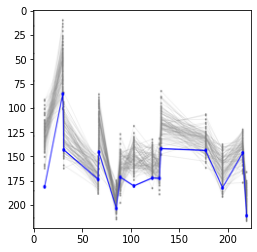

In [50]:
i = 11
#print(cnv_info_df.iloc[i,:])
print(pcgc_split_cnv_images_list[i])
func_dl.showImg(img_np[i])

### Generage labels

In [25]:
# true_label = [1 for i in range(0,len(true_img_np))]
# false_label = [0 for i in range(0,len(false_img_np))]
# print(true_label[0:5], false_label[0:5])
# print(len(true_label), len(false_label))

### Combine true & false data

In [26]:
# combined_cnv_info_df = true_cnv_df.append(false_cnv_df, ignore_index=True)
# #combined_cnv_info_index = list(range(len(combined_cnv_info_df)))
# combined_img_np = np.vstack((true_img_np, false_img_np))
# combined_label = true_label + false_label

In [27]:
# combined_cnv_info_df.shape, true_cnv_df.shape, false_cnv_df.shape

## Normalization

In [19]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [51]:
# Change to float datatype
img_np = img_np.astype('float32')

# Scale the data to lie between 0 to 1
img_np /= 255

In [52]:
# Find the unique numbers from the train labels
nClasses = 3
print('Total number classes: ', nClasses)

Total number classes:  3


/home/rt2776/cnv_espresso/predict_pcgc/images_new/split_cnvs/15_1-00296_5_166386727_173073664_NA_DEL_NAtgs_389wins_splits194_120.png


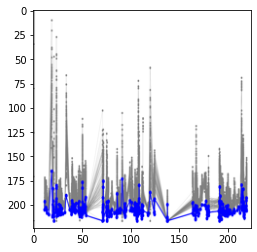

In [61]:
item = random.randint(0,len(img_np))
# print(cnv_info_df.iloc[item,:])
print(pcgc_split_cnv_images_list[item])
func_dl.showImg(img_np[item])

## Precision

In [98]:
## Load pre-calculated model
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}

model_name = 'MobileNet_v1'
model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5'
# model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold4.h5'
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

Loading MobileNet_v1 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5


In [99]:
img_pred = MobileNet_model.predict(img_np)

In [100]:
img_pred

array([[6.51469901e-02, 3.00285757e-01, 6.34567201e-01],
       [9.15902729e-06, 7.33049936e-04, 9.99257743e-01],
       [3.56968712e-07, 1.81040687e-05, 9.99981523e-01],
       [1.12023525e-01, 7.10655630e-01, 1.77320868e-01],
       [1.37279168e-01, 8.62477064e-01, 2.43791772e-04],
       [9.96248782e-01, 3.15983384e-03, 5.91443386e-04],
       [4.48297083e-01, 5.51521182e-01, 1.81737749e-04],
       [3.17618833e-04, 1.55716809e-03, 9.98125255e-01],
       [3.18621518e-04, 2.08889768e-01, 7.90791571e-01],
       [1.91724484e-05, 1.27745827e-03, 9.98703361e-01],
       [1.12023525e-01, 7.10655630e-01, 1.77320868e-01],
       [8.24820474e-02, 9.17000413e-01, 5.17540495e-04],
       [3.50763116e-06, 4.32152650e-04, 9.99564350e-01],
       [1.14009276e-01, 8.75648022e-01, 1.03427311e-02],
       [6.67972386e-01, 5.71256795e-04, 3.31456393e-01],
       [8.27847868e-02, 1.02360263e-01, 8.14854920e-01],
       [5.26736374e-04, 9.32271257e-02, 9.06246185e-01],
       [9.99911427e-01, 8.63309

In [101]:
# for pcgc split cnvs
# item =  883
# # print(cnv_info_df.iloc[item,:])
# print(pcgc_split_cnv_images_list[item])
# print(img_pred[item,:])
# func_dl.showImg(img_np[item])


In [116]:
pred_output_df = copy.deepcopy(cnv_info_df)
pred_output_df.shape

(52, 18)

In [117]:
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

pred_output_df.insert(pred_output_df.shape[1], 'Prob_DEL', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prob_DIP', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prob_DUP', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prob', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prediction', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Status', "-")

4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


In [118]:
pred_output_df['CNV_TYPE'] = pred_output_df['CNV_TYPE'].replace(1,"DEL")
pred_output_df['CNV_TYPE'] = pred_output_df['CNV_TYPE'].replace(3,"DUP")

In [120]:
num, correct_count = 0, 0
for i in range(len(img_pred)):
    num += 1
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DEL')] = img_pred[i][0]
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DIP')] = img_pred[i][1]
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DUP')] = img_pred[i][2]
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob')] = np.max(img_pred[i])
    
    if(np.argmax(img_pred[i]) == 0):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DEL"
    elif(np.argmax(img_pred[i]) == 1):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DIP"
    elif(np.argmax(img_pred[i]) == 2):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DUP"
    else:
        pdb.set_trace()
        
    if pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] == pred_output_df.iloc[i,pred_output_df.columns.get_loc('CNV_TYPE')]:
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Status')] = "Correct"
    else:
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Status')] = "Incorrect"
    

In [121]:
accuracy_rate = len(pred_output_df[pred_output_df['Status'] == "Correct"])/len(pred_output_df)
print("Accuracy rate:",accuracy_rate)

Accuracy rate: 0.7115384615384616


In [122]:
## output to file
output_path = '/home/rt2776/cnv_espresso/predict_pcgc/'
pred_output_df.to_csv(output_path+'pcgc_NimbleGenV2_data_prediction0223.csv',index=False)
pred_output_df.to_excel(output_path+'pcgc_NimbleGenV2_data_prediction0223.xlsx',index=False)
pred_output_df

,ID,Chr,Start,End,Band,CNV_TYPE,Syndrome_or_Gene,AnalysisObserved†,CardiacLesion(Diagnosis),ParentOrigin,...,batch,Num_Targets_Wins,entire_cnv_path,split_cnv_path,Prob_DEL,Prob_DIP,Prob_DUP,Prob,Prediction,Status
0,1-01401,1,59247993,59251097,p32.1,DEL,JUN,A,LVOT(HLHS),-,...,NimbleGenV2,1,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,0.065147,0.300286,0.634567,0.634567,DUP,Incorrect
1,1-03171,1,145586403,145799634,q21.1,DUP,"1q21.1,dup_or_GJA5‡","A,E",CTD(TOF_or_APVS),-,...,NimbleGenV2,50,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,9.15903e-06,0.00073305,0.999258,0.999258,DUP,Correct
2,1-01036,1,146631133,147416212,q21.1,DUP,"1q21.1,dup_or_GJA5‡",E,CTD(TOF),M,...,NimbleGenV2,75,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,3.56969e-07,1.81041e-05,0.999982,0.999982,DUP,Correct
3,1-01486,1,194201171,194304070,q24.2–q25,DUP,CDC73,A,LVOT(HLHS),-,...,NimbleGenV2,0,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,0.112024,0.710656,0.177321,0.710656,DIP,Incorrect
4,1-01536,2,70168995,70359345,p13.3,DEL,PCBP1,A,CTD(TOF_or_PA),-,...,NimbleGenV2,4,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,0.137279,0.862477,0.000243792,0.862477,DIP,Incorrect
5,1-01401,2,102493466,103001458,q11.2–q12.1,DEL,MAP4K4,E,LVOT(HLHS),-,...,NimbleGenV2,52,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,0.996249,0.00315983,0.000591443,0.996249,DEL,Correct
6,1-01401,2,145155868,145274931,q22.3,DEL,Mowat-Wilson_or_ZEB2‡,E,LVOT(HLHS),-,...,NimbleGenV2,9,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,0.448297,0.551521,0.000181738,0.551521,DIP,Incorrect
7,1-00762,3,60661,11712230,p26.1,DUP,"ARL8B,ARPC4,CAMK1,CAV3,CRBN,EMC3,ITPR1,SEC13,S...",A,ASD_or_PS(ASD),-,...,NimbleGenV2,664,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,0.000317619,0.00155717,0.998125,0.998125,DUP,Correct
8,1-01049,3,15637812,15643461,p25.1,DUP,"BTD,HACL1",E,CTD(TOF),-,...,NimbleGenV2,4,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,0.000318622,0.20889,0.790792,0.790792,DUP,Correct
9,1-01045,3,47780965,48309270,p21.31,DUP,"CDC25A,DHX30,MAP4,SMARCC1",A,LVOT(HLHS),-,...,NimbleGenV2,69,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,1.91724e-05,0.00127746,0.998703,0.998703,DUP,Correct


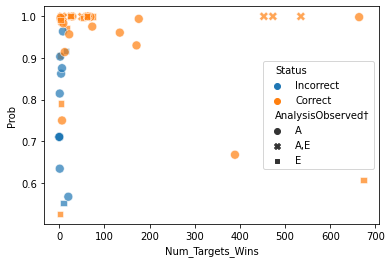

In [176]:
output_path = '/home/rt2776/cnv_espresso/images_rare_3classes/figures/'
output_file = output_path+'pcgc_prediction.png'

fig = sns.scatterplot(data=pred_output_df ,x="Num_Targets_Wins", y="Prob",hue="Status", 
                style="AnalysisObserved†",legend="brief",s=80,alpha=0.7)
#splot.set(xscale="log")

plt.savefig(output_file, facecolor='w', edgecolor='w', bbox_inches = 'tight',dpi=150)

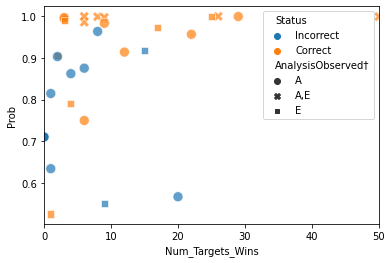

In [182]:
fig = sns.scatterplot(data=pred_output_df ,x="Num_Targets_Wins", y="Prob",hue="Status", 
                style="AnalysisObserved†",legend="auto",s=100, alpha=0.7)
plt.xlim(0, 50)

output_file = output_path+'pcgc_prediction_zoomin.png'
plt.savefig(output_file, facecolor='w', edgecolor='w', bbox_inches = 'tight',dpi=150)

### Predict specific images

In [ ]:
# # ## For splited rare duplications
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_dup_splits.list'

In [ ]:
# true_cnv_df  = pd.read_csv(true_file,  header=None,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=None,sep='\t')

In [ ]:
# true_cnv_df.columns = ['image_path']
# false_cnv_df.columns = ['image_path']

In [ ]:
# #specific_images_path_df = false_cnv_df[false_cnv_df['image_path'].str.contains('SP0009081')]
# specific_images_path_df = true_cnv_df[true_cnv_df['image_path'].str.contains('SP0077668_2_172795024')]
# specific_images_path_list = specific_images_path_df['image_path']
# specific_images_path_list

In [ ]:
# img_width, img_height = 224, 224
# specific_img_np = loadImgs(specific_images_path_list, img_width, img_height)

In [ ]:
# specific_img_np.shape

In [ ]:
# specific_img_np = specific_img_np.astype('float32')
# specific_img_np /= 255

In [ ]:
# showImg(specific_img_np[2])

In [ ]:
# MobileNet_model.predict(specific_img_np)

In [ ]:
# np.argmax(MobileNet_model.predict(specific_img_np)[2])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a